###Skin Cancer Detection with Machine Learning (Notebook 1)
Alyona Kosobokova, Matthew Ongcapin, Pawan Bishwokarma, Tommy Poole


##Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from functools import partial

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC

import cv2
from tqdm import tqdm

import re
import os

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Import & Validation

In [ ]:
folder_path = '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data'
files = os.listdir(folder_path)
print(files)

['ISIC_2024_Permissive_Training_Input', 'ISIC_2024_Permissive_Training_Supplement.csv', 'ISIC_2024_Permissive_Training_GroundTruth.csv', 'metadata.csv']


In [ ]:
metadata1_df = pd.read_csv('/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_GroundTruth.csv', engine='python')
metadata1_df.head()

,isic_id,malignant
0,ISIC_0015670,0.0
1,ISIC_0015845,0.0
2,ISIC_0015864,0.0
3,ISIC_0015902,0.0
4,ISIC_0024200,0.0


In [ ]:
#Get a sum of the malignant column
malignant = metadata1_df['malignant'].sum()
print(f'Number of cancerous cases = {malignant}')

Number of cancerous cases = 294.0


In [ ]:
metadata1_df.tail()

,isic_id,malignant
217472,ISIC_9999854,0.0
217473,ISIC_9999919,0.0
217474,ISIC_9999951,0.0
217475,ISIC_9999960,0.0
217476,ISIC_9999967,0.0


In [ ]:
# Filter for values where malignant > 0.0
filtered_df = metadata1_df[metadata1_df['malignant'] > 0.0]

# Print the filtered DataFrame
print(filtered_df)

             isic_id  malignant
544     ISIC_0096034        1.0
714     ISIC_0104229        1.0
1023    ISIC_0119495        1.0
1928    ISIC_0157834        1.0
2662    ISIC_0190307        1.0
...              ...        ...
214325  ISIC_9855202        1.0
216126  ISIC_9941636        1.0
216856  ISIC_9972649        1.0
216860  ISIC_9972877        1.0
217397  ISIC_9996602        1.0

[294 rows x 2 columns]


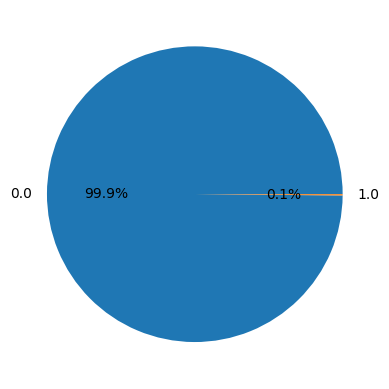

In [ ]:
x = metadata1_df['malignant'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

In [ ]:
#print the total count of each category, malignant and benign
print(f'Total number of cases = {len(metadata1_df)}')
print(f'Number of malignant cases = {malignant}')
print(f'Number of benign cases = {len(metadata1_df) - malignant}')

#Print the number of cases that are malignant versus benign in the dataset
print(f'Percentage of malignant cases = {malignant/len(metadata1_df):.4f}')

#Print formatted as a percentage
print(f'Percentage of malignant cases = {malignant/len(metadata1_df):.4%}')

Total number of cases = 217477
Number of malignant cases = 294.0
Number of benign cases = 217183.0
Percentage of malignant cases = 0.0014
Percentage of malignant cases = 0.1352%


In [ ]:
metadata2_df = pd.read_csv('/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Supplement.csv')
metadata2_df.head()

,isic_id,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [ ]:
print(metadata2_df.shape)

(217477, 13)


In [ ]:
#print column titles
print(metadata2_df.columns)

Index(['isic_id', 'attribution', 'copyright_license', 'lesion_id', 'iddx_full',
       'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index',
       'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')


In [ ]:
image_path = '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input'
jpeg_files = list(tqdm(glob(f"{image_path}/*"), desc="Loading files"))
print(jpeg_files[:3])

Loading files: 100%|██████████| 60919/60919 [00:00<00:00, 1636266.33it/s]

['/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/ISIC_2805699.jpg', '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/ISIC_2805787.jpg', '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/ISIC_2805868.jpg']


In [ ]:
image_path = '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input'
jpeg_files = os.listdir(image_path)
#print the first 3 files to validate correct path
print(jpeg_files[:3])

['ISIC_2805699.jpg', 'ISIC_2805787.jpg', 'ISIC_2805868.jpg']


##Data Pre-Processing

In [ ]:
images = glob(f"{image_path}/*.jpg")
print(images[:3])
len(images)

['/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/ISIC_2805699.jpg', '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/ISIC_2805787.jpg', '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/ISIC_2805868.jpg']


60918

In [ ]:
#create a dataframe of images using the glob
images_df = pd.DataFrame(images, columns=['filepath'])

# Function to extract the last "ISIC_***"" portion of the filepath as the filename
def extract_isic_filename(filepath):
    match = re.search(r'(ISIC_\d+\.jpg)', filepath)
    return match.group(1) if match else filepath

# Apply the function to the 'filepath' column
images_df['filepath'] = images_df['filepath'].apply(extract_isic_filename)

# Display the updated DataFrame
images_df.head()

,filepath
0,ISIC_2805699.jpg
1,ISIC_2805787.jpg
2,ISIC_2805868.jpg
3,ISIC_2805904.jpg
4,ISIC_2805913.jpg


In [ ]:
print(len(images_df))

60918


In [ ]:
# Add a new column in the images dataframe that converts the file path name before .jpg starting with and including 'ISIC...' ending before '.jpg'
images_df['isic_id'] = images_df['filepath'].apply(lambda x: re.search(r'ISIC_\d+', x).group(0) if re.search(r'ISIC_\d+', x) else None)
images_df.head()

,filepath,isic_id
0,ISIC_2805699.jpg,ISIC_2805699
1,ISIC_2805787.jpg,ISIC_2805787
2,ISIC_2805868.jpg,ISIC_2805868
3,ISIC_2805904.jpg,ISIC_2805904
4,ISIC_2805913.jpg,ISIC_2805913


In [ ]:
# Merge df_images with metadata1_df on isic_id, add 'malignant' column as a column labled 'target'
images_df = images_df.merge(metadata1_df, left_on='isic_id', right_on='isic_id', how='left')

#rename column title 'malignant' to 'target'
images_df.rename(columns={'malignant': 'target'}, inplace=True)

images_df.head()

,filepath,isic_id,target
0,ISIC_2805699.jpg,ISIC_2805699,0.0
1,ISIC_2805787.jpg,ISIC_2805787,0.0
2,ISIC_2805868.jpg,ISIC_2805868,0.0
3,ISIC_2805904.jpg,ISIC_2805904,0.0
4,ISIC_2805913.jpg,ISIC_2805913,0.0


In [ ]:
# Sum the malignant column of df_images
malignant = images_df['target'].sum()
print(f'Number of cancerous cases = {malignant}')

Number of cancerous cases = 76.0


In [ ]:
#print the total count of each category, malignant and benign for the images_df
print(f'Total number of cases = {len(images_df)}')
print(f'Number of malignant cases = {malignant}')
print(f'Number of benign cases = {len(images_df) - malignant}')

#Print the number of cases that are malignant versus benign in the dataset
print(f'Percentage of malignant cases = {malignant/len(images_df):.4f}')

#Print formatted as a percentage
print(f'Percentage of malignant cases = {malignant/len(images_df):.4%}')

Total number of cases = 60918
Number of malignant cases = 76.0
Number of benign cases = 60842.0
Percentage of malignant cases = 0.0012
Percentage of malignant cases = 0.1248%


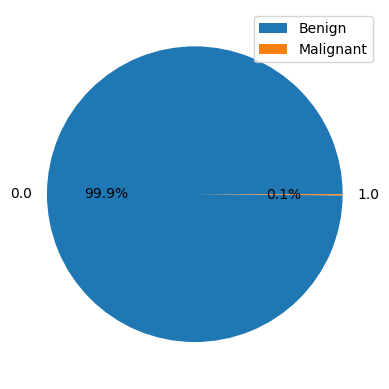

In [ ]:
# Create a pie chart of the images data to show benign and malignant cases
x = images_df['target'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
#add a legend
plt.legend(['Benign', 'Malignant'])

plt.show()

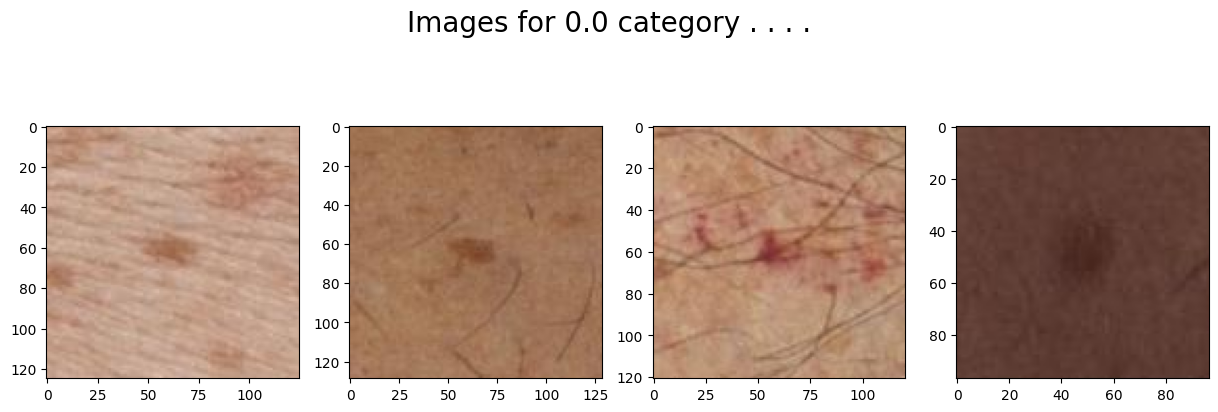

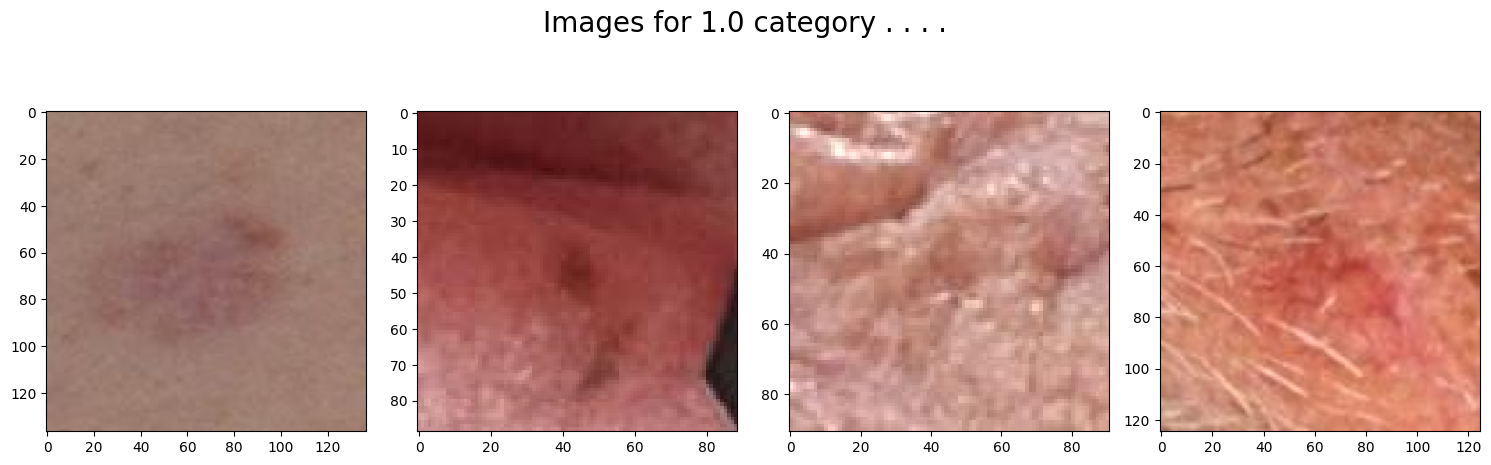

In [ ]:
for cat in images_df['target'].unique():
    temp = images_df[images_df['target'] == cat]

    index_list = temp.index
    # Check if index_list is empty
    if len(index_list) > 0:
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
        for i in range(4):
            # Generate random index within the valid range
            index = np.random.randint(0, len(index_list))
            index = index_list[index]
            data = images_df.iloc[index]

            image_path = data[0]

            img = np.array(Image.open('/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/' + image_path))
            ax[i].imshow(img)
    else:
        print(f"Skipping category '{cat}' due to empty index list.")
plt.tight_layout()
plt.show()

In [ ]:
#Oversampling to account for imbalanced

# Set X as our feature matrix and y as our target vector
X = images_df[['filepath']]
y = images_df['target']

ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Apply RandomOverSampler to balance the classes
X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the new class distribution
print(f"Original class distribution: {Counter(y)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")

# Combine X_resampled and y_resampled back into a single DataFrame
resampled_df = X_resampled.copy()
resampled_df['target'] = y_resampled

# Now resampled_df contains all your original columns, including 'target'
print(resampled_df.head())
print(resampled_df.columns)

Original class distribution: Counter({0.0: 60842, 1.0: 76})
Resampled class distribution: Counter({0.0: 60842, 1.0: 60842})
           filepath  target
0  ISIC_2805699.jpg     0.0
1  ISIC_2805787.jpg     0.0
2  ISIC_2805868.jpg     0.0
3  ISIC_2805904.jpg     0.0
4  ISIC_2805913.jpg     0.0
Index(['filepath', 'target'], dtype='object')


In [ ]:
# Createa a random subset for model creation effeciency
# Create a filtered dataframe of a random 5% of the resampled group
filtered_images_df = resampled_df.sample(frac=0.05, random_state=42)

# Reset the index of the filtered dataframe
filtered_images_df.reset_index(drop=True, inplace=True)

print((f"total number of resampled images: {len(filtered_images_df)}"))
filtered_images_df.head()

total number of resampled images: 6084


,filepath,target
0,ISIC_1645097.jpg,1.0
1,ISIC_0565021.jpg,1.0
2,ISIC_0521019.jpg,1.0
3,ISIC_2299573.jpg,1.0
4,ISIC_1119276.jpg,0.0


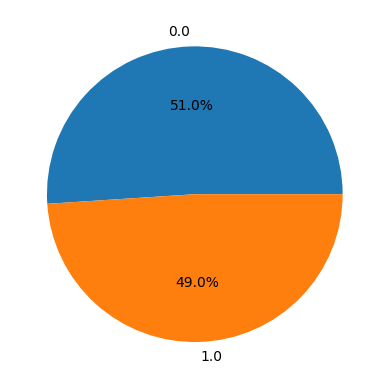

In [ ]:
x_filtered = filtered_images_df['target'].value_counts()
plt.pie(x_filtered.values,
        labels=x_filtered.index,
        autopct='%1.1f%%')
plt.show()

In [ ]:
# Createa a random subset for final testing against an unbalanced dataset
# Create a filtered dataframe of a random 5% of the originals
images_df_final_test = images_df.sample(frac=0.05, random_state=42)

# Reset the index of the filtered dataframe
images_df_final_test.reset_index(drop=True, inplace=True)

print((f"total number of resampled images: {len(filtered_images_df)}"))
images_df_final_test.head()

total number of resampled images: 6084


,filepath,isic_id,target
0,ISIC_2757216.jpg,ISIC_2757216,0.0
1,ISIC_2298534.jpg,ISIC_2298534,0.0
2,ISIC_2570514.jpg,ISIC_2570514,0.0
3,ISIC_1196405.jpg,ISIC_1196405,0.0
4,ISIC_1941197.jpg,ISIC_1941197,0.0


##EffecientNetB7 Model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [ ]:
features = filtered_images_df['filepath']
target = filtered_images_df['target']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape

((5171,), (913,))

In [ ]:
def decode_image(filepath, label):
    # Print a few file paths to verify they're correct
    file_path = '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/' + filepath

    # Debug print for the first few images
    if tf.random.uniform([]) < 0.01:  # Print 1% of paths for debugging
        print(f"Attempting to load: {file_path}")

    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)

        # Add debug prints for image shape and values
        if tf.random.uniform([]) < 0.01:
            print(f"Image shape after decode: {img.shape}")
            print(f"Image min/max values: {tf.reduce_min(img)}, {tf.reduce_max(img)}")

        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, tf.float32) / 255.0

        return img, label

    except tf.errors.InvalidArgumentError as e:
        print(f"Error decoding image {file_path}: {e}")
        return tf.zeros([224, 224, 3], dtype=tf.float32), label

In [ ]:
# Print a few examples of your file paths
print("Sample file paths:")
print(filtered_images_df['filepath'].head())

# Verify that files exist
import os
print("\nChecking if files exist:")
for filepath in filtered_images_df['filepath'].head():
    full_path = os.path.join('/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/', filepath)
    print(f"File {filepath}: {'Exists' if os.path.exists(full_path) else 'Does NOT exist'}")

Sample file paths:
0    ISIC_1645097.jpg
1    ISIC_0565021.jpg
2    ISIC_0521019.jpg
3    ISIC_2299573.jpg
4    ISIC_1119276.jpg
Name: filepath, dtype: object

Checking if files exist:
File ISIC_1645097.jpg: Exists
File ISIC_0565021.jpg: Exists
File ISIC_0521019.jpg: Exists
File ISIC_2299573.jpg: Exists
File ISIC_1119276.jpg: Exists


Successfully loaded with OpenCV
Image shape: (151, 151, 3)


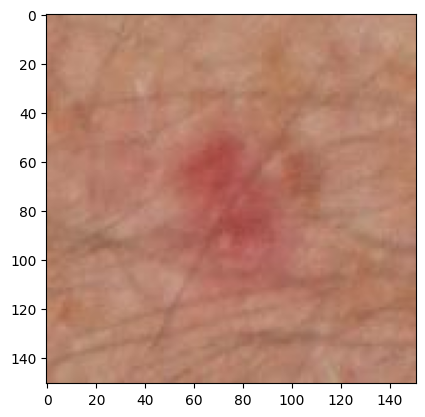

Successfully loaded with TensorFlow
Image shape: (151, 151, 3)


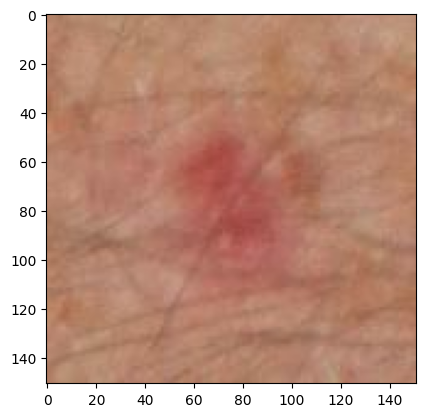

In [ ]:
# Test loading a single image
test_path = filtered_images_df['filepath'].iloc[0]
full_path = '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/' + test_path

# Try loading with OpenCV
import cv2
img = cv2.imread(full_path)
if img is not None:
    print("Successfully loaded with OpenCV")
    print(f"Image shape: {img.shape}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Failed to load with OpenCV")

# Try loading with TensorFlow
try:
    img = tf.io.read_file(full_path)
    img = tf.image.decode_jpeg(img)
    print("Successfully loaded with TensorFlow")
    print(f"Image shape: {img.shape}")
    plt.imshow(img)
    plt.show()
except Exception as e:
    print(f"Failed to load with TensorFlow: {e}")

In [ ]:
# Create the training dataset
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(52)
    .prefetch(tf.data.AUTOTUNE)
)

# Create the validation dataset
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(52)
    .prefetch(tf.data.AUTOTUNE)
)

Attempting to load: Tensor("add:0", shape=(), dtype=string)
Image shape after decode: (None, None, 3)
Image min/max values: Tensor("cond_1/Min:0", shape=(), dtype=uint8), Tensor("cond_1/Max:0", shape=(), dtype=uint8)
Attempting to load: Tensor("add:0", shape=(), dtype=string)
Image shape after decode: (None, None, 3)
Image min/max values: Tensor("cond_1/Min:0", shape=(), dtype=uint8), Tensor("cond_1/Max:0", shape=(), dtype=uint8)


Verifying training dataset:
Batch shape: (52, 224, 224, 3)
Labels shape: (52,)
Labels: [0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 1.]
Unique labels: [0. 1.]
Image min value: 0.0
Image max value: 1.0


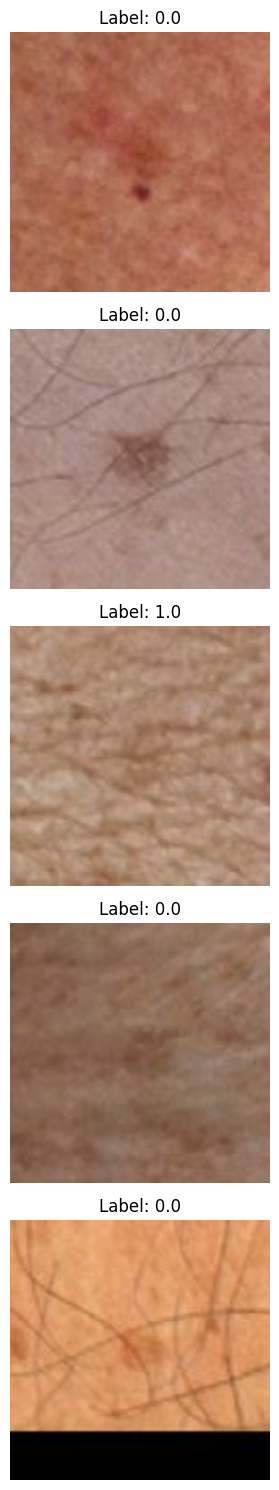


Verifying validation dataset:
Batch shape: (52, 224, 224, 3)
Labels shape: (52,)
Labels: [0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 0.]
Unique labels: [0. 1.]
Image min value: 0.0
Image max value: 1.0


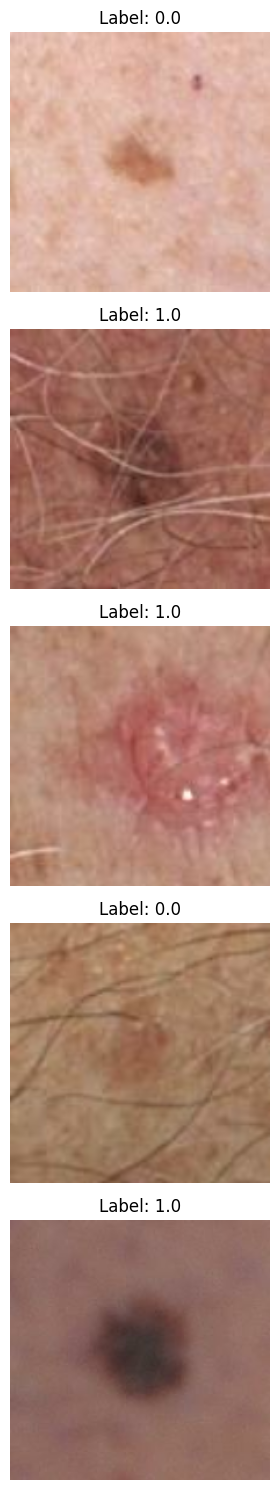

In [ ]:
# Function to visualize a batch of images with their labels
def visualize_batch(images, labels, num_images=5):
    plt.figure(figsize=(15, 3*num_images))
    for i in range(min(num_images, len(images))):
        plt.subplot(num_images, 1, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Verify a batch from the dataset
def verify_dataset(dataset, num_batches=1):
    for images, labels in dataset.take(num_batches):
        print(f"Batch shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Labels: {labels.numpy()}")
        print(f"Unique labels: {np.unique(labels.numpy())}")
        print(f"Image min value: {tf.reduce_min(images)}")
        print(f"Image max value: {tf.reduce_max(images)}")
        visualize_batch(images, labels)

# Use these functions to verify your datasets
print("Verifying training dataset:")
verify_dataset(train_ds)  # Use train_ds instead of Y_train

print("\nVerifying validation dataset:")
verify_dataset(val_ds)    # Use val_ds instead of Y_val

In [ ]:
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

for layer in pre_trained_model.layers:
    layer.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(120, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(120, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model after it is redefined
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['AUC']
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    verbose=1)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 450s 4s/step - AUC: 0.7009 - loss: 0.6716 - val_AUC: 0.6882 - val_loss: 2.1063
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 721ms/step - AUC: 0.9159 - loss: 0.3759 - val_AUC: 0.4884 - val_loss: 4.2824
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 735ms/step - AUC: 0.9638 - loss: 0.2454 - val_AUC: 0.9087 - val_loss: 0.4667
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 836ms/step - AUC: 0.9613 - loss: 0.2570 - val_AUC: 0.9708 - val_loss: 1.6378
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 774ms/step - AUC: 0.9889 - loss: 0.1344 - val_AUC: 0.5000 - val_loss: 10.7178


In [ ]:
print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))

Train samples: 5171
Validation samples: 913


In [ ]:
print("Number of batches in train_ds:", len(list(train_ds)))
print("Number of batches in val_ds:", len(list(val_ds)))

Number of batches in train_ds: 100
Number of batches in val_ds: 18


In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.811635,0.544990,0.688189,2.106254
1,0.929684,0.343013,0.488369,4.282404
2,0.958768,0.261259,0.908749,0.466748
3,0.970606,0.219625,0.970800,1.637804
4,0.985511,0.152198,0.500000,10.717793


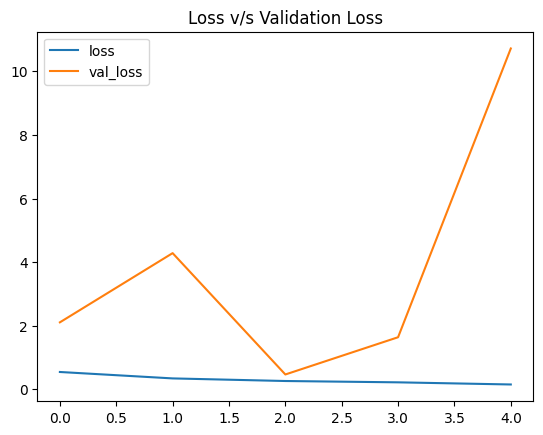

In [ ]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

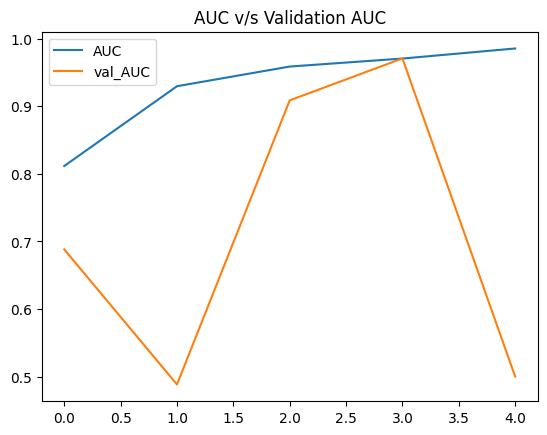

In [ ]:
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()

In [ ]:
# Evaluate performance after training
# Get predictions
train_predictions = model.predict(train_ds)
val_predictions = model.predict(val_ds)

# Get actual labels (assuming your datasets return (x, y) tuples)
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Calculate various metrics
print("Training Metrics:")
print("-----------------")
print(f"Loss: {train_loss:.4f}")
print(f"Accuracy: {train_acc * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(train_labels, train_predictions):.4f}")
print("\nTraining Classification Report:")
print(classification_report(train_labels, (train_predictions > 0.5).astype(int)))

print("\nValidation Metrics:")
print("-----------------")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(val_labels, val_predictions):.4f}")
print("\nValidation Classification Report:")
print(classification_report(val_labels, (val_predictions > 0.5).astype(int)))

# Print confusion matrices
print("\nTraining Confusion Matrix:")
print(confusion_matrix(train_labels, (train_predictions > 0.5).astype(int)))
print("\nValidation Confusion Matrix:")
print(confusion_matrix(val_labels, (val_predictions > 0.5).astype(int)))

100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step
Training Metrics:
-----------------
Loss: 10.6156
Accuracy: 50.04%
AUC-ROC: 0.5153

Training Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      2640
         1.0       0.49      1.00      0.66      2531

    accuracy                           0.49      5171
   macro avg       0.74      0.50      0.33      5171
weighted avg       0.75      0.49      0.32      5171


Validation Metrics:
-----------------
Loss: 10.7178
Accuracy: 50.00%
AUC-ROC: 0.5015

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       465
         1.0       0.49      1.00      0.66       448

    accuracy                           0.49       913
   macro avg       0.25      0.50      0.33       913
weighted avg       0.24      0.49      0.32       913


Training Confusion Matr

NOTE: This model is overfitting on the training data, and not generalizing well as implemented. NOTE: Performance improved lowering the number of layers from 256 to 120 after 4 epochs, and degraded on the 5th.

# SVM Model

In [ ]:
# Function to extract batch features with progress bar
def extract_batch_features(image_paths):
    features = []
    valid_indices = []
    for idx, path in tqdm(enumerate(image_paths), total=len(image_paths), desc="Processing images"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            features.append(img.flatten())
            valid_indices.append(idx)
        else:
            print(f'Image not found or could not be opened: {path}')
    return np.array(features), valid_indices

# Process images for the whole dataset
X_features, valid_indices = extract_batch_features('/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/' + filtered_images_df['filepath'])

Processing images: 100%|██████████| 6084/6084 [00:42<00:00, 141.99it/s]


In [ ]:
# Filter the DataFrame to keep only rows with valid features
filtered_df = filtered_images_df.iloc[valid_indices].reset_index(drop=True)

# Check if there are any valid features extracted
if X_features.shape[0] == 0:
    print("No valid features extracted. Exiting.")
else:
    print(f"X_features shape: {X_features.shape}")
    print(f"filtered_df shape: {filtered_df.shape}")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, filtered_df['target'], test_size=0.2, random_state=42, stratify=filtered_df['target']
    )

    # Create and train the SVM model
    model = SVC(kernel='linear', random_state=42)
    print("Training SVM model...")
    with tqdm(total=100, desc="Training progress") as pbar:
        model.fit(X_train, y_train)
        pbar.update(100)

    # Make predictions on the test set
    print("Making predictions...")
    y_pred = []
    for x in tqdm(X_test, desc="Predicting"):
        y_pred.append(model.predict([x])[0])

    # Evaluate performance using classification report
    report = classification_report(y_test, y_pred)
    print(report)

X_features shape: (6084, 4096)
filtered_df shape: (6084, 2)
Training SVM model...


Training progress: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


Making predictions...


Predicting: 100%|██████████| 1217/1217 [00:04<00:00, 257.09it/s]

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       621
         1.0       0.98      1.00      0.99       596

    accuracy                           0.99      1217
   macro avg       0.99      0.99      0.99      1217
weighted avg       0.99      0.99      0.99      1217



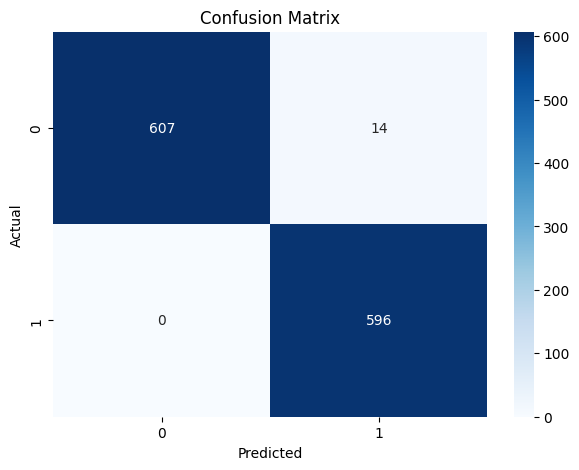

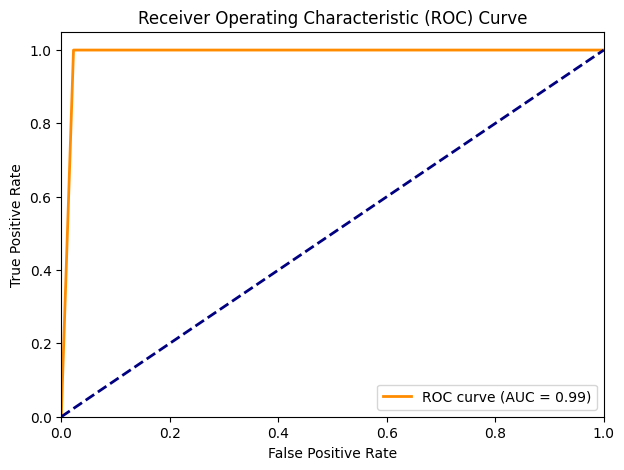

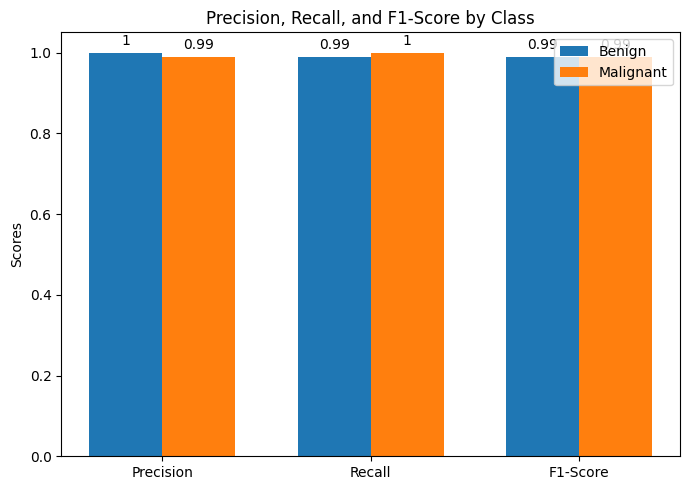

In [ ]:
# Using visualizations to illustrate the results
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Bar Plot
metrics = ['Precision', 'Recall', 'F1-Score']
class_0 = [1.00, 0.99, 0.99]
class_1 = [0.99, 1.00, 0.99]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar([i - width/2 for i in x], class_0, width, label='Benign')
rects2 = ax.bar([i + width/2 for i in x], class_1, width, label='Malignant')

ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

# THE CNN Model


In [ ]:
images_df = filtered_images_df

In [ ]:
# Define the CNN model
def create_cnn_model(input_shape=(64, 64, 3)):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
folder_path = '/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input/'

In [ ]:
def prepare_data(images_df, target_size=(64, 64)):
    X = []
    # Wrap the image loading process in a tqdm progress bar
    for img_path in tqdm(folder_path + images_df['filepath'], desc='Loading and resizing images', total=len(images_df)):
        img = cv2.imread(img_path)
        if img is not None:  # Check if image was loaded successfully
            resized_img = cv2.resize(img, target_size)
            X.append(resized_img)
        else:
            print(f'Warning: Could not load image at path: {img_path}')  # Print a warning for failed image loads
    X = np.array(X)
    y = images_df['target'].values
    return X, y

# Training setup
def train_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Create and compile model
    model = create_cnn_model()
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC()])

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight={0: 1., 1: len(y_train[y_train==0])/len(y_train[y_train==1])}
    )

    return model, history, (X_test, y_test)

# Main execution
def main():
    # Prepare data
    X, y = prepare_data(images_df)

    # Train model
    model, history, test_data = train_model(X, y)

    # Evaluate model
    X_test, y_test = test_data
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    return model, history

In [ ]:
if __name__ == "__main__":
    model, history = main()

Loading and resizing images: 100%|██████████| 6084/6084 [00:49<00:00, 123.28it/s]


Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 31s 233ms/step - accuracy: 0.5784 - auc_2: 0.5841 - loss: 2.1752 - val_accuracy: 0.6119 - val_auc_2: 0.7664 - val_loss: 0.6100 - learning_rate: 0.0010
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - accuracy: 0.6812 - auc_2: 0.7396 - loss: 0.6120 - val_accuracy: 0.7218 - val_auc_2: 0.8255 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 282ms/step - accuracy: 0.7204 - auc_2: 0.7985 - loss: 0.5601 - val_accuracy: 0.7741 - val_auc_2: 0.8415 - val_loss: 0.5433 - learning_rate: 0.0010
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - accuracy: 0.7267 - auc_2: 0.7938 - loss: 0.5664 - val_accuracy: 0.8162 - val_auc_2: 0.8875 - val_loss: 0.4747 - learning_rate: 0.0010
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 243ms/step - accuracy: 0.7734 - auc_2: 0.8500 - loss: 0.4942 - val_accuracy: 0.7690 - val_auc_2: 0.9071 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 39s 2

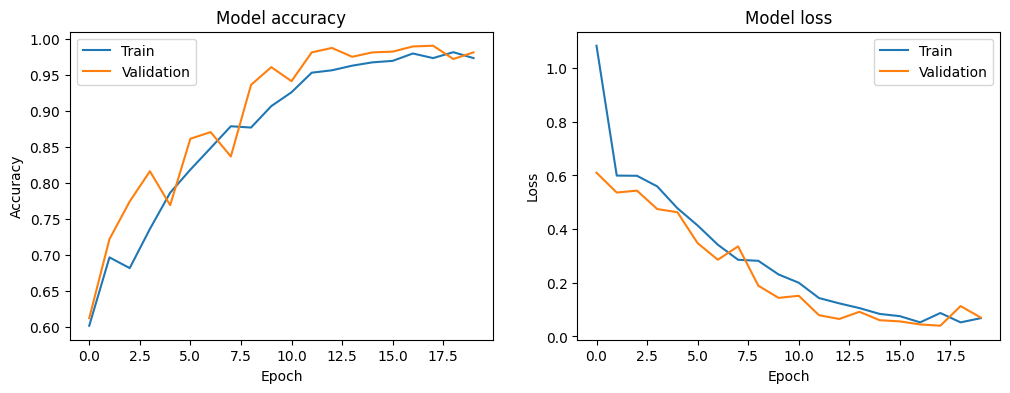

In [ ]:
# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

plot_history(history)

#Next
Consider validation against not oversampled dataset here
OR
Consider trying to account for bias in underrepresented populations

In [ ]:
# Prepare the unbalanced test data using the same preparation function
X_test, y_test = prepare_data(images_df_final_test, target_size=(64, 64))

# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)

# Get detailed predictions
predictions = model.predict(X_test)

# Calculate comprehensive metrics
print("\nTest Results on Unbalanced Dataset:")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Print detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_test, (predictions > 0.5).astype(int)))

# Show confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, (predictions > 0.5).astype(int)))


Loading and resizing images: 100%|██████████| 3046/3046 [11:44<00:00,  4.33it/s]


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9876 - auc_2: 0.5970 - loss: 0.0563
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step

Test Results on Unbalanced Dataset:
Test accuracy: 0.9833
Test AUC: 0.9980
Test loss: 0.0753

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      3044
         1.0       0.04      1.00      0.07         2

    accuracy                           0.98      3046
   macro avg       0.52      0.99      0.53      3046
weighted avg       1.00      0.98      0.99      3046


Confusion Matrix:
[[2993   51]
 [   0    2]]
